# Time series analysis

In [63]:
import pandas as pd
import numpy as np

# KMEANS
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer 
from yellowbrick.cluster import silhouette_visualizer 

# Visualization
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"
import matplotlib.pyplot as plt
import seaborn as sns
# geo (visualization)
import fiona
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

pd.set_option('display.max_columns', None)

In [81]:
# Read datasets
df_temperature = pd.read_csv("./datasets/CityGlobalTemperature2000-2009.csv", index_col=0) # index_col takes the index from the csv rather than creating it automatically (i.e. unnamed col is removed)

In [82]:
df_temperature.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01


## Data Anlaysis

Null values and Type analysis

In [65]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1813 to 239132
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             12000 non-null  float64
 1   AverageTemperatureUncertainty  12000 non-null  float64
 2   City                           12000 non-null  object 
 3   Country                        12000 non-null  object 
 4   Latitude                       12000 non-null  object 
 5   Longitude                      12000 non-null  object 
 6   time                           12000 non-null  object 
dtypes: float64(2), object(5)
memory usage: 750.0+ KB


I verify that each city has the same Country, Latitude and Longitude in all its records.

In [66]:
something_different = False

for city in df_temperature.City.unique():
    query = df_temperature['City'] == city

    if not df_temperature[query].loc[:, 'Country'].eq(df_temperature[query].loc[:, 'Country'].iloc[0]).all():
        something_different = True
        print(city + ' has different Country')
    if not df_temperature[query].loc[:, 'Latitude'].eq(df_temperature[query].loc[:, 'Latitude'].iloc[0]).all():
        something_different = True
        print(city + ' has different Latitude')
    if not df_temperature[query].loc[:, 'Longitude'].eq(df_temperature[query].loc[:, 'Longitude'].iloc[0]).all():
        something_different = True
        print(city + ' has different Longitude')

if not something_different:
    print('Each city has the same Country, Latitude and Longitude')

Each city has the same Country, Latitude and Longitude


Studying the uncertanty related to average temperature for each city

In [67]:
df_temperature.sort_values(by='AverageTemperatureUncertainty')

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
49249,-1.004,0.056,Changchun,China,44.20N,125.22E,2004-11-01
79052,26.198,0.068,Guangzhou,China,23.31N,112.72E,2001-05-01
143541,27.217,0.071,Manila,Philippines,15.27N,120.83E,2009-06-01
105472,9.733,0.075,Jinan,China,36.17N,117.35E,2000-03-01
160428,18.110,0.080,Nagoya,Japan,34.56N,136.22E,2007-05-01
...,...,...,...,...,...,...,...
124313,24.852,2.577,Lahore,Pakistan,31.35N,73.51E,2006-04-01
72541,24.852,2.577,Faisalabad,Pakistan,31.35N,73.51E,2006-04-01
135581,23.028,2.622,Luanda,Angola,8.84S,13.78E,2002-07-01
135616,23.396,2.673,Luanda,Angola,8.84S,13.78E,2005-06-01


In [68]:
df_city = df_temperature.groupby('City').agg('mean')
df_city = df_city.join(df_temperature.groupby('City').Country.first())
df_city = df_city.join(df_temperature.groupby('City').Latitude.first())
df_city = df_city.join(df_temperature.groupby('City').Longitude.first())

px.scatter_3d(df_city, x = 'Longitude', y='Latitude', z='AverageTemperatureUncertainty', color='Country')

## Data Transformation and Feature Engegneering

Creating 12 new attributes related to the average temperature that occured in each month across all the years.

In [69]:
df_temperature['year'] = pd.DatetimeIndex(df_temperature['time']).year
df_temperature['month'] = pd.DatetimeIndex(df_temperature['time']).month

df_moths_average_temp = df_temperature.set_index('City').pivot_table('AverageTemperature', 'City', 'month').rename_axis(None, axis=1)#.reset_index(drop=True)
df_moths_average_temp

df_city = df_city.join(df_moths_average_temp, on='City')
df_city

,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude,1,2,3,4,5,6,7,8,9,10,11,12
City,,,,,,,,,,,,,,,,,
Abidjan,26.930375,0.386550,Côte D'Ivoire,5.63N,3.23W,27.2104,28.6023,28.9006,28.2400,27.5392,26.0854,25.1940,24.8005,25.4952,26.3535,27.3589,27.3845
Addis Abeba,18.351717,0.566192,Ethiopia,8.84N,38.11E,18.2615,19.4287,20.1868,20.0349,19.9104,18.2156,17.0864,17.1638,17.5866,17.4151,17.4975,17.4333
Ahmadabad,27.416742,0.449108,India,23.31N,72.52E,20.2431,22.7144,27.5728,31.5733,33.5029,32.0304,29.0154,27.8735,28.7618,28.3600,25.4374,21.9159
Aleppo,18.345783,0.344408,Syria,36.17N,37.79E,6.0204,7.8457,12.4506,16.8803,22.3965,27.7393,30.6218,30.1781,26.0022,20.3516,12.4561,7.2068
Alexandria,21.331192,0.292550,Egypt,31.35N,30.16E,14.8878,14.9763,17.1055,19.2533,22.1642,25.2457,27.3494,27.8062,26.5975,23.7940,20.3589,16.4355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tokyo,13.370042,0.226267,Japan,36.17N,139.23E,2.0084,3.1993,6.5052,11.9995,16.6967,20.5148,24.1534,24.9984,21.3098,15.1640,9.5840,4.3070
Toronto,6.934975,0.223225,Canada,44.20N,80.50W,-6.8175,-6.5381,-1.5354,5.8324,11.9252,17.7160,19.6951,19.3907,15.8131,8.6788,3.0395,-3.9801
Umm Durman,29.882492,0.528875,Sudan,15.27N,32.50E,23.1234,25.6489,28.8060,32.7768,34.5343,34.3116,31.9165,30.7415,31.7856,32.0204,28.5019,24.4230


Transforming latitude and longitude from String to int

In [70]:
# conversion functions
def latitude_to_float(latitude):

    if(latitude[-1] == 'N'):
        return float(latitude[0:-1])
    elif(latitude[-1] == 'S'):
        return - float(latitude[0:-1])
    else:
        print('Conversion error: ' + latitude)

def longitude_to_float(longitude):

    if(longitude[-1] == 'W'):
        return - float(longitude[0:-1])
    elif(longitude[-1] == 'E'):
        return float(longitude[0:-1])
    else:
        print('Conversion error: ' + longitude)


# applying conversions
df_city.Latitude = df_city.Latitude.apply(lambda x: latitude_to_float(x))
df_city.Longitude = df_city.Longitude.apply(lambda x: longitude_to_float(x))
df_city

,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude,1,2,3,4,5,6,7,8,9,10,11,12
City,,,,,,,,,,,,,,,,,
Abidjan,26.930375,0.386550,Côte D'Ivoire,5.63,-3.23,27.2104,28.6023,28.9006,28.2400,27.5392,26.0854,25.1940,24.8005,25.4952,26.3535,27.3589,27.3845
Addis Abeba,18.351717,0.566192,Ethiopia,8.84,38.11,18.2615,19.4287,20.1868,20.0349,19.9104,18.2156,17.0864,17.1638,17.5866,17.4151,17.4975,17.4333
Ahmadabad,27.416742,0.449108,India,23.31,72.52,20.2431,22.7144,27.5728,31.5733,33.5029,32.0304,29.0154,27.8735,28.7618,28.3600,25.4374,21.9159
Aleppo,18.345783,0.344408,Syria,36.17,37.79,6.0204,7.8457,12.4506,16.8803,22.3965,27.7393,30.6218,30.1781,26.0022,20.3516,12.4561,7.2068
Alexandria,21.331192,0.292550,Egypt,31.35,30.16,14.8878,14.9763,17.1055,19.2533,22.1642,25.2457,27.3494,27.8062,26.5975,23.7940,20.3589,16.4355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tokyo,13.370042,0.226267,Japan,36.17,139.23,2.0084,3.1993,6.5052,11.9995,16.6967,20.5148,24.1534,24.9984,21.3098,15.1640,9.5840,4.3070
Toronto,6.934975,0.223225,Canada,44.20,-80.50,-6.8175,-6.5381,-1.5354,5.8324,11.9252,17.7160,19.6951,19.3907,15.8131,8.6788,3.0395,-3.9801
Umm Durman,29.882492,0.528875,Sudan,15.27,32.50,23.1234,25.6489,28.8060,32.7768,34.5343,34.3116,31.9165,30.7415,31.7856,32.0204,28.5019,24.4230


In [71]:
df_city.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Abidjan to Xian
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             100 non-null    float64
 1   AverageTemperatureUncertainty  100 non-null    float64
 2   Country                        100 non-null    object 
 3   Latitude                       100 non-null    float64
 4   Longitude                      100 non-null    float64
 5   1                              100 non-null    float64
 6   2                              100 non-null    float64
 7   3                              100 non-null    float64
 8   4                              100 non-null    float64
 9   5                              100 non-null    float64
 10  6                              100 non-null    float64
 11  7                              100 non-null    float64
 12  8                              100 non-null    f

## Cluster

In [72]:
features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

df_data = df_city[features].reset_index(drop=True)
df_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,27.2104,28.6023,28.9006,28.2400,27.5392,26.0854,25.1940,24.8005,25.4952,26.3535,27.3589,27.3845
1,18.2615,19.4287,20.1868,20.0349,19.9104,18.2156,17.0864,17.1638,17.5866,17.4151,17.4975,17.4333
2,20.2431,22.7144,27.5728,31.5733,33.5029,32.0304,29.0154,27.8735,28.7618,28.3600,25.4374,21.9159
3,6.0204,7.8457,12.4506,16.8803,22.3965,27.7393,30.6218,30.1781,26.0022,20.3516,12.4561,7.2068
4,14.8878,14.9763,17.1055,19.2533,22.1642,25.2457,27.3494,27.8062,26.5975,23.7940,20.3589,16.4355
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.0084,3.1993,6.5052,11.9995,16.6967,20.5148,24.1534,24.9984,21.3098,15.1640,9.5840,4.3070
96,-6.8175,-6.5381,-1.5354,5.8324,11.9252,17.7160,19.6951,19.3907,15.8131,8.6788,3.0395,-3.9801
97,23.1234,25.6489,28.8060,32.7768,34.5343,34.3116,31.9165,30.7415,31.7856,32.0204,28.5019,24.4230
98,4.5549,7.5392,12.4869,18.1027,23.0371,26.7031,29.7552,28.3623,24.7555,19.0946,12.5024,6.4549


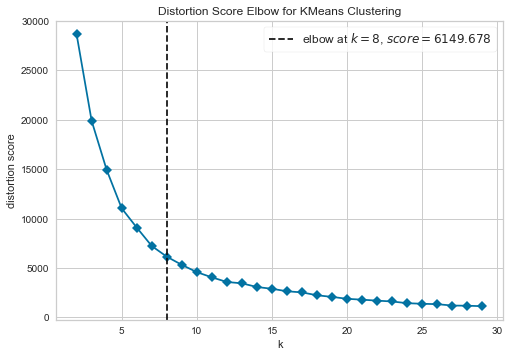

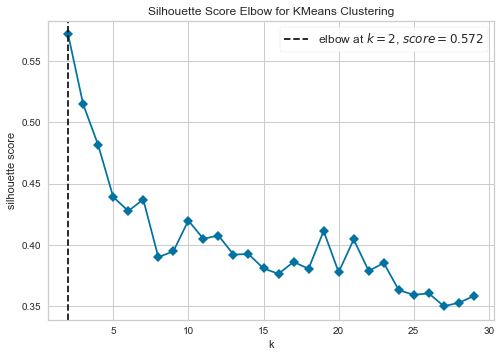

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [73]:
model = KMeans(n_init=10, max_iter=100, init="k-means++")
sse_visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
sse_visualizer.fit(df_data)
sse_visualizer.show()

sil_visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric="silhouette")
sil_visualizer.fit(df_data)
sil_visualizer.show()

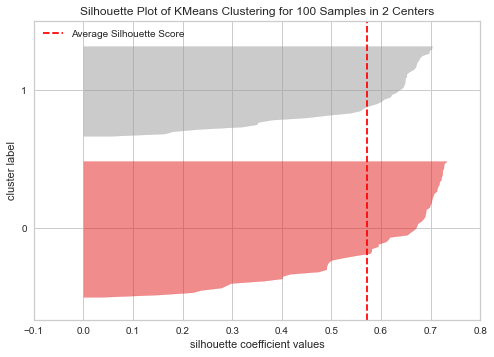

The silhoutte score is: 0.5719825583542005


In [84]:
optimal_k = 2#sse_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=100, init="k-means++")
kmeans.fit(df_data)

df_city["cluster_kmeans"] = kmeans.labels_.astype(str)

x = silhouette_visualizer(KMeans(optimal_k, random_state=42), df_data)
print("The silhoutte score is: " + str(x.silhouette_score_))

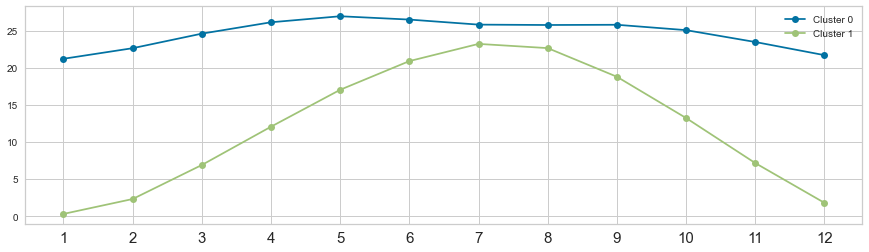

In [85]:
plt.figure(figsize=(15, 4))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(df_data.columns)), df_data.columns, fontsize=15)
plt.legend(fontsize=10)
plt.show()

In [86]:
df_city.groupby("cluster_kmeans").agg({"cluster_kmeans":"count", "AverageTemperature": "mean", 1: "mean", 2: "mean", 3: "mean", 4: "mean", 5: "mean", 6: "mean", 7: "mean", 8: "mean", 9: "mean", 10: "mean", 11: "mean", 12: "mean"}).sort_values(by="AverageTemperature", ascending=False).round(2).rename(columns={"cluster_kmeans": "cluster size"})

,cluster size,AverageTemperature,1,2,3,4,5,6,7,8,9,10,11,12
cluster_kmeans,,,,,,,,,,,,,,
0,60,24.70,21.26,22.69,24.66,26.20,27.01,26.56,25.88,25.83,25.86,25.13,23.53,21.75
1,40,12.23,0.30,2.32,6.91,12.09,17.08,20.95,23.27,22.71,18.84,13.26,7.18,1.81


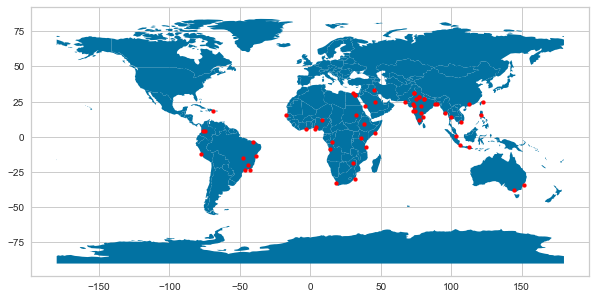

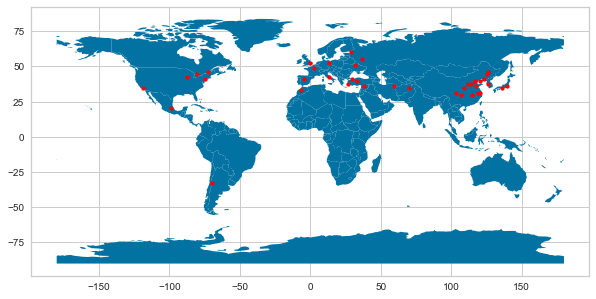

In [87]:
# plotting the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

for i in range(0, optimal_k):
    
    filter = (df_city['cluster_kmeans'] == str(i))
    #df_city[filter]

    geometry = [Point(xy) for xy in zip(df_city[filter]['Longitude'], df_city[filter]['Latitude'])]
    gdf = GeoDataFrame(df_city[filter], geometry=geometry)   

    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
